# Chemotaxonomy

Hiearchical clustering of plants based on their chemical composition

### Import modules

In [46]:
from collections import defaultdict
import itertools as itt
import math
from typing import Dict, Set, Any
import os

import pandas as pd
from tqdm import tqdm
import numpy as np

# Import taxonomy
from utils import get_genus_and_family_info_for_plants

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering


from rdkit.DataStructs import TanimotoSimilarity
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit import RDLogger  

In [2]:
RDLogger.DisableLog('rdApp.*')

In [3]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 360
%matplotlib inline

In [4]:
tqdm.pandas()
pd.set_option('display.max_columns', None)

Load chemicals

In [5]:
plant_chemical_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_chemical_associations.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

In [6]:
plant_chemical_df.head(1)

,plant_curie,chemical_curie
0,ncbitaxon:1000425,pubchem.compound:3527


In [7]:
len(plant_chemical_df.chemical_curie.unique()), len(plant_chemical_df.plant_curie.unique())

(87019, 19802)

Convert the SMILEs to PubChem ids

In [8]:
smiles_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/smiles.tsv.gz',
    sep='\t',
    compression='gzip',
    usecols=[
        'pubchem_id',
        'smiles',
    ],
)

In [9]:
smiles_df.shape

(89271, 2)

In [10]:
smiles_dict = {}
for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    smiles_dict[pubchem_id] = smiles  

100%|██████████| 89271/89271 [00:00<00:00, 618446.40it/s]


In [11]:
pubchem_to_smiles = {}
all_smiles = set()

chemicals_in_plants = set(plant_chemical_df.chemical_curie.unique())

for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    if pubchem_id not in chemicals_in_plants:
        continue
    
    all_smiles.add(smiles)
    pubchem_to_smiles[pubchem_id] = smiles

smiles_to_pubchem = {
    smiles: pubchem
    for pubchem, smiles in pubchem_to_smiles.items()
}

100%|██████████| 89271/89271 [00:00<00:00, 551066.30it/s]


In [12]:
len(smiles_to_pubchem)

87019

### Calculate chemical similarity across all pairs of chemicals

In [13]:
# make a list of mols
pubchem_to_mol = {
    pubchem: Chem.MolFromSmiles(smiles)
    for pubchem, smiles in pubchem_to_smiles.items()
}

# pubchem morgan
pubchem_to_morgan = {
    pubchem: rdMolDescriptors.GetMorganFingerprint(mol, 2)
    for pubchem, mol in pubchem_to_mol.items()
}

In [14]:
len(pubchem_to_morgan)

87019

### Create similarity matrix

In [15]:
plant_chem_dict = defaultdict(set)
chemicals_to_plant_dict = defaultdict(set)

for plant_curie, chemical_curie in tqdm(plant_chemical_df.values):
    plant_chem_dict[plant_curie].add(chemical_curie)
    chemicals_to_plant_dict[chemical_curie].add(plant_curie)

100%|██████████| 383591/383591 [00:01<00:00, 368455.21it/s]


Tag chemicals that are prenent in more than 100 plants, since they are likely to be common primary metabolites

In [22]:
promiscuous_chemicals = [
    chemical
    for chemical, plants in chemicals_to_plant_dict.items()
    if len(plants) > 25
    # Ensure there are no secondary metabolites present in a lot of plants (25)
    # Since they will skew the results for plants that have a lot chemicals compared to others
]

plant_chem_dict = {
    plant: {
        chemical
        for chemical in chemicals
        if chemical not in promiscuous_chemicals
    }
    for plant, chemicals in plant_chem_dict.items()
}

In [24]:
len(promiscuous_chemicals)

2430

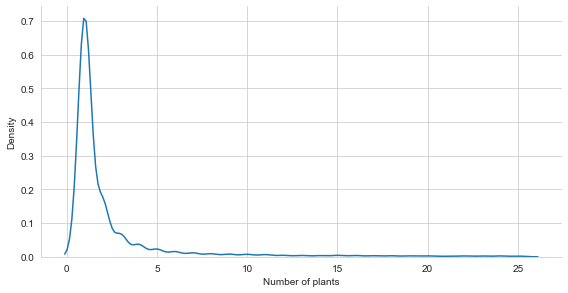

In [25]:
g = sns.displot(
    [
        len(plants)
        for chemical, plants in chemicals_to_plant_dict.items()
        if chemical not in promiscuous_chemicals
    ],
    kind="kde",
    height=4,
    aspect=2,
)

g.set_axis_labels("Number of plants", "Density")
g.set_titles("Distribution of plants per chemical")

plt.show()

Build the similarity matrix

In [26]:
def calculate_plant_similarity(
    plant_a: str,
    plant_b: str,
    plant_to_chemicals: Dict[str, Set[str]],
    pubchem_to_morgan: Dict[str, Any],
    top_percentage_1: int,
    top_percentage_2: int,
    top_percentage_3: int,
):
    """Calculate the similarity between two plants."""
    similarities = []
    
    for chemical_plant_a, chemical_plant_b in itt.product(plant_to_chemicals[plant_a], plant_to_chemicals[plant_b]):
        
        # Calculate tanimoto similarity
        similarities.append(
            TanimotoSimilarity(
                pubchem_to_morgan[chemical_plant_a],
                pubchem_to_morgan[chemical_plant_b],
            )
        )
    
    # Take the top percentage of similarities
    top_percentage_1 = int((len(plant_to_chemicals[plant_a]) * len(plant_to_chemicals[plant_b])) / top_percentage_1)
    top_percentage_2 = int((len(plant_to_chemicals[plant_a]) * len(plant_to_chemicals[plant_b])) / top_percentage_2)
    top_percentage_3 = int((len(plant_to_chemicals[plant_a]) * len(plant_to_chemicals[plant_b])) / top_percentage_3)
        
    # Return the average of the top percentage
    return (
        sum(sorted(similarities, reverse=True)[:top_percentage_1]) / top_percentage_1,
        sum(sorted(similarities, reverse=True)[:top_percentage_2]) / top_percentage_2,
        sum(sorted(similarities, reverse=True)[:top_percentage_3]) / top_percentage_3,
    )


In [27]:
def num_combinations(n, r):
    """Calculate the number of combinations of n choose r."""
    return math.factorial(n) // (math.factorial(r) * math.factorial(n-r))

In [28]:
similarity_matrix_path_5 = './final_similarity_dataframe_5.tsv'
similarity_matrix_path_1 = './final_similarity_dataframe_1.tsv'
similarity_matrix_path_2 = './final_similarity_dataframe_2.tsv'

# Read similarity matrix from cache
# if os.path.exists(similarity_matrix_path_5):
#     # Read the similarity matrix from cache
#     similarity_dataframe = pd.read_csv(
#         similarity_matrix_path_5,
#         sep='\t',
#         index_col=0,
#     )

# # Generate similarity matrix if it doesnt yet exist
# else:
# use only plants with more than 20 chemicals
plant_curies = [
    plant
    for plant in plant_chemical_df.plant_curie.unique()
    if plant in plant_chem_dict and len(plant_chem_dict[plant]) > 20 and plant.startswith('ncbitaxon:')
]

print(f'{len(plant_curies)} plants included in the analysis')

# Create a dataframe to store the similarity matrix
similarity_dataframe_5 = pd.DataFrame(
    0.0,
    index=plant_curies,
    columns=plant_curies,
)

similarity_dataframe_1 = pd.DataFrame(
    0.0,
    index=plant_curies,
    columns=plant_curies,
)

similarity_dataframe_2 = pd.DataFrame(
    0.0,
    index=plant_curies,
    columns=plant_curies,
)

count = 0

# Calculate the similarity between all pairs of plants
for plant_a, plant_b in tqdm(
    itt.combinations_with_replacement(plant_curies, r=2),
    total=num_combinations(len(plant_curies), 2),
):

    sim_5, sim_1, sim_2 = calculate_plant_similarity(
        plant_a=plant_a,
        plant_b=plant_b,
        plant_to_chemicals=plant_chem_dict,
        pubchem_to_morgan=pubchem_to_morgan,
        top_percentage_1=5,
        top_percentage_2=1,
        top_percentage_3=2,
    )
    
    # Cache the similarity matrix every 100k iterations
    if count % 500000 == 0:
        similarity_dataframe_5.to_csv(
            './similarity_dataframe_5.tsv',
            sep='\t',
        )

        similarity_dataframe_1.to_csv(
            './similarity_dataframe_1.tsv',
            sep='\t',
        )
        similarity_dataframe_2.to_csv(
            './similarity_dataframe_2.tsv',
            sep='\t',
        )
        print(f'df exported at {round(count / num_combinations(len(plant_curies), 2), 4)*100}%')
    
    similarity_dataframe_5[plant_a][plant_b] = sim_5
    similarity_dataframe_5[plant_b][plant_a] = sim_5

    similarity_dataframe_1[plant_a][plant_b] = sim_1
    similarity_dataframe_1[plant_b][plant_a] = sim_1
    
    similarity_dataframe_2[plant_a][plant_b] = sim_2
    similarity_dataframe_2[plant_b][plant_a] = sim_2
    
    count += 1

similarity_dataframe_5.to_csv(
    similarity_matrix_path_5,
    sep='\t',
)

similarity_dataframe_1.to_csv(
    similarity_matrix_path_1,
    sep='\t',
)

similarity_dataframe_2.to_csv(
    similarity_matrix_path_2,
    sep='\t',
)

2591 plants included in the analysis


  0%|          | 22/3355345 [00:07<218:58:21,  4.26it/s]

df exported at 0.0%


 15%|█▍        | 500054/3355345 [1:02:02<51:16:11, 15.47it/s]

df exported at 14.899999999999999%


 30%|██▉       | 1000013/3355345 [2:00:50<150:52:13,  4.34it/s]

df exported at 29.799999999999997%


 45%|████▍     | 1500020/3355345 [3:14:11<115:25:01,  4.47it/s]

df exported at 44.7%


 60%|█████▉    | 2000014/3355345 [4:18:25<112:18:51,  3.35it/s]

df exported at 59.61%


 75%|███████▍  | 2500024/3355345 [5:48:52<41:46:44,  5.69it/s] 

df exported at 74.51%


 89%|████████▉ | 3000033/3355345 [7:11:59<17:15:54,  5.72it/s] 

df exported at 89.41%


3357936it [7:43:33, 120.73it/s]                               


In [29]:
similarity_dataframe_1.shape

(2591, 2591)

In [30]:
similarity_dataframe_1.head(1)

,ncbitaxon:1000430,ncbitaxon:100165,ncbitaxon:100170,ncbitaxon:1004000,ncbitaxon:100504,ncbitaxon:100514,ncbitaxon:100532,ncbitaxon:1006183,ncbitaxon:1008903,ncbitaxon:1009467,ncbitaxon:1009474,ncbitaxon:1009475,ncbitaxon:1009487,ncbitaxon:1009495,ncbitaxon:1009507,ncbitaxon:1009589,ncbitaxon:101007,ncbitaxon:101596,ncbitaxon:101743,ncbitaxon:102107,ncbitaxon:102773,ncbitaxon:1028359,ncbitaxon:1031519,ncbitaxon:103351,ncbitaxon:1034035,ncbitaxon:1034059,ncbitaxon:103480,ncbitaxon:103482,ncbitaxon:103485,ncbitaxon:1037435,ncbitaxon:1037789,ncbitaxon:103973,ncbitaxon:1040884,ncbitaxon:1040889,ncbitaxon:1042512,ncbitaxon:104301,ncbitaxon:1045175,ncbitaxon:1045233,ncbitaxon:1046528,ncbitaxon:1048892,ncbitaxon:1048926,ncbitaxon:105181,ncbitaxon:1053410,ncbitaxon:105388,ncbitaxon:1055008,ncbitaxon:1055022,ncbitaxon:1055476,ncbitaxon:105667,ncbitaxon:105674,ncbitaxon:105748,ncbitaxon:105884,ncbitaxon:105891,ncbitaxon:105906,ncbitaxon:106041,ncbitaxon:106130,ncbitaxon:106132,ncbitaxon:106335,ncbitaxon:106710,ncbitaxon:106723,ncbitaxon:1071187,ncbitaxon:1071199,ncbitaxon:107240,ncbitaxon:107308,ncbitaxon:1073774,ncbitaxon:1082640,ncbitaxon:108278,ncbitaxon:108362,ncbitaxon:108409,ncbitaxon:108412,ncbitaxon:1084670,ncbitaxon:1084686,ncbitaxon:108543,ncbitaxon:108544,ncbitaxon:108545,ncbitaxon:108546,ncbitaxon:108594,ncbitaxon:108868,ncbitaxon:108881,ncbitaxon:1089406,ncbitaxon:1089417,ncbitaxon:1089418,ncbitaxon:1090620,ncbitaxon:1090621,ncbitaxon:109063,ncbitaxon:1095360,ncbitaxon:109792,ncbitaxon:109817,ncbitaxon:109849,ncbitaxon:1108177,ncbitaxon:1112727,ncbitaxon:1114760,ncbitaxon:1115783,ncbitaxon:1118758,ncbitaxon:1123437,ncbitaxon:112400,ncbitaxon:112408,ncbitaxon:112538,ncbitaxon:112603,ncbitaxon:1127059,ncbitaxon:1127152,ncbitaxon:1127154,ncbitaxon:1127184,ncbitaxon:1128102,ncbitaxon:1130977,ncbitaxon:1132458,ncbitaxon:113423,ncbitaxon:113636,ncbitaxon:1140079,ncbitaxon:1142948,ncbitaxon:114476,ncbitaxon:114509,ncbitaxon:114617,ncbitaxon:1149812,ncbitaxon:1155363,ncbitaxon:1157238,ncbitaxon:116752,ncbitaxon:1170222,ncbitaxon:117798,ncbitaxon:117808,ncbitaxon:117953,ncbitaxon:118510,ncbitaxon:118778,ncbitaxon:1190424,ncbitaxon:119172,ncbitaxon:119176,ncbitaxon:119186,ncbitaxon:119260,ncbitaxon:119261,ncbitaxon:1197921,ncbitaxon:1199110,ncbitaxon:120273,ncbitaxon:120290,ncbitaxon:120625,ncbitaxon:1209843,ncbitaxon:1209881,ncbitaxon:1210110,ncbitaxon:121073,ncbitaxon:121082,ncbitaxon:121177,ncbitaxon:121542,ncbitaxon:1220089,ncbitaxon:122319,ncbitaxon:1224772,ncbitaxon:1224773,ncbitaxon:1225667,ncbitaxon:1225829,ncbitaxon:1226103,ncbitaxon:1226104,ncbitaxon:1226113,ncbitaxon:1227638,ncbitaxon:122812,ncbitaxon:122814,ncbitaxon:123397,ncbitaxon:123405,ncbitaxon:123407,ncbitaxon:123445,ncbitaxon:123477,ncbitaxon:123485,ncbitaxon:123599,ncbitaxon:1237540,ncbitaxon:1237573,ncbitaxon:1237717,ncbitaxon:1237720,ncbitaxon:1239894,ncbitaxon:1240870,ncbitaxon:1245227,ncbitaxon:124772,ncbitaxon:124778,ncbitaxon:124779,ncbitaxon:124781,ncbitaxon:124782,ncbitaxon:124789,ncbitaxon:124790,ncbitaxon:124791,ncbitaxon:124793,ncbitaxon:124943,ncbitaxon:124947,ncbitaxon:124949,ncbitaxon:125257,ncbitaxon:125587,ncbitaxon:126273,ncbitaxon:126367,ncbitaxon:126418,ncbitaxon:126436,ncbitaxon:1265830,ncbitaxon:126644,ncbitaxon:126675,ncbitaxon:126678,ncbitaxon:126774,ncbitaxon:126820,ncbitaxon:1271630,ncbitaxon:1277777,ncbitaxon:1279044,ncbitaxon:127980,ncbitaxon:127999,ncbitaxon:128017,ncbitaxon:1280199,ncbitaxon:128292,ncbitaxon:128375,ncbitaxon:128597,ncbitaxon:128605,ncbitaxon:128609,ncbitaxon:128640,ncbitaxon:128655,ncbitaxon:128685,ncbitaxon:128687,ncbitaxon:128702,ncbitaxon:1288014,ncbitaxon:128805,ncbitaxon:129201,ncbitaxon:12953,ncbitaxon:1297881,ncbitaxon:13006,ncbitaxon:13007,ncbitaxon:130138,ncbitaxon:130235,ncbitaxon:130376,ncbitaxon:130382,ncbitaxon:130389,ncbitaxon:130404,ncbitaxon:130411,ncbitaxon:130414,ncbitaxon:130418,ncbitaxon:1304319,ncbitaxon:13044,ncbitaxon:13091,ncbitaxon:13098,ncbitaxon:13102,ncbitaxon:13129,ncbitaxon:1317901,ncbita

Plot distribution of the similarities for the entire dataframe

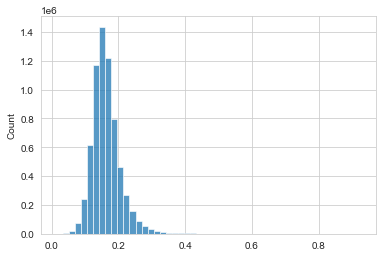

In [75]:
all_values = similarity_dataframe_2.stack().reset_index(drop=True)
sns.histplot(all_values, bins=50)
plt.show()

In [113]:
# # Create the dissimilarity matrix for each row of the similarity matrix using 1-s where s is the similarity
# distance_matrix = scipy.spatial.distance.pdist(
#     similarity_dataframe_1,
#     metric='euclidean',
# )

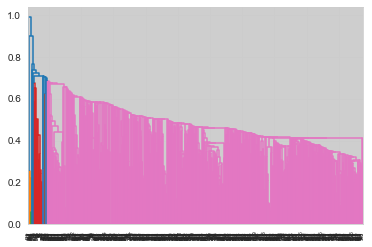

In [114]:
# Create the linkage matrix

# TODO: uncomment
# distance_matrix = 1 - similarity_dataframe_filtered

Z = linkage(
    distance_matrix,
    method='single',
)

# Plot the dendrogram
dn = dendrogram(Z)
plt.show()

Visualization of the clusters, now we have to draw a line on the dendrogram to define the clusters and compare them with actual taxonomic genera/families

#### Get the real taxonomical clades (ground truth)

In [35]:
genus_to_species, family_to_species = get_genus_and_family_info_for_plants(
    set(similarity_dataframe_1.index),
)

order genus: 100%|██████████| 16884/16884 [00:00<00:00, 29790.80it/s]


In [36]:
len(genus_to_species), len(family_to_species)

(1324, 265)

In [37]:
species_to_genus = {
    plant: genus
    for genus, species in genus_to_species.items()
    if len(species) > 5  # skip genera with less than 5 species
    for plant in species
}

species_to_family = {
    plant: family
    for family, species in family_to_species.items()
    for plant in species
}

In [38]:
len(species_to_genus), len(species_to_family)

(680, 2579)

Get clusters using a cutoff that gives us a closer number of clusters to the actual ones we know exist (cell above)

In [121]:
labels_pred_genera = fcluster(Z, len(genus_to_species), criterion='maxclust')

labels_pred_families = fcluster(Z, len(family_to_species), criterion='maxclust')

In [122]:
max(labels_pred_families), max(labels_pred_genera)

(265, 676)

In [131]:
genus_plants_to_consider = list(species_to_genus.keys())

similarity_dataframe_filtered = similarity_dataframe_2.loc[
    similarity_dataframe_2.index.isin(genus_plants_to_consider),
    genus_plants_to_consider
]

similarity_dataframe_filtered = similarity_dataframe_filtered.reindex(
    columns=genus_plants_to_consider,
    index=genus_plants_to_consider,
)

distance_matrix = 1 - similarity_dataframe_filtered

clustering_genus = AgglomerativeClustering(
    n_clusters=len(genus_plants_to_consider),
    affinity='precomputed',
    linkage='single',
)

clustering_genus.fit(distance_matrix)

labels_pred_genera = clustering_genus.labels_

clustering_family = AgglomerativeClustering(
    n_clusters=len(family_to_species),
    affinity='precomputed',
    linkage='single',
)

clustering_family.fit(distance_matrix)

labels_pred_families = clustering_family.labels_

In [132]:
max(labels_pred_genera), max(labels_pred_families)

(679, 264)

Join clusters to actual species assignements 

In [133]:
def prepare_data_for_evaluation(
    labels_pred: np.ndarray,
    species_to_clade: Dict[str, str],
    similarity_dataframe: pd.DataFrame,
):
    """Prepare the data for evaluation."""
    ground_truth = []
    predicted_clusters = []

    for cluster, plant in zip(labels_pred, similarity_dataframe.index):
        predicted_clusters.append(cluster)
        ground_truth.append(species_to_clade[plant])
    
    return predicted_clusters, ground_truth


predicted_clusters_genus, ground_truth_genus = prepare_data_for_evaluation(
    labels_pred=labels_pred_genera,
    species_to_clade=species_to_genus,
    similarity_dataframe=similarity_dataframe_filtered,
)

predicted_clusters_family, ground_truth_family = prepare_data_for_evaluation(
    labels_pred=labels_pred_families,
    species_to_clade=species_to_family,
    similarity_dataframe=similarity_dataframe_filtered,
)

In [134]:
len(labels_pred_genera), len(similarity_dataframe_filtered.index)

(680, 680)

In [135]:
adjusted_rand_score(predicted_clusters_family, ground_truth_family)

0.016561554095002932

In [136]:
adjusted_rand_score(predicted_clusters_genus, ground_truth_genus)

0.0